# **Final Model**

In [ ]:
# importing all libraries

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
# reading data

df = pd.read_csv('data.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
# shape of dataset

df.shape

(381109, 12)

In [ ]:
# removing unwanted columns

columns_to_remove = ['id', 'Driving_License']
df.drop(columns=columns_to_remove, inplace=True)

In [22]:
# reducing categories in region code column 
region_counts = df['Region_Code'].value_counts()
df['Region_Code'] = [i if region_counts[i] >= 6280 else 1.0 for i in df['Region_Code']]

# changing datatype to str
df['Region_Code'] = df['Region_Code'].astype(str)

In [ ]:
# reducing categories in region code column

policy_sales_channel_count = df['Policy_Sales_Channel'].value_counts()
df['Policy_Sales_Channel'] = [i if policy_sales_channel_count[i] >= 1360 else 1.0 for i in df['Policy_Sales_Channel']]

# changing datatype to str
df['Policy_Sales_Channel'] =df['Policy_Sales_Channel'].astype(str)

In [ ]:
# encoding vehicle age column

df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}).astype(int)

In [ ]:
# splitting data into X and y

X = df.drop(columns='Response')
y = df['Response']

In [ ]:
# splitting data for training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# capping values with maximum values (removing outliers)

X_train['Annual_Premium'] = [i if i < 61000 else 61000 for i in X_train['Annual_Premium']]

In [ ]:
# creating pipeline which will perfomr one-hot encoding and min-max scaling on dataset

# columns to one hot encode
ohe_columns = ['Region_Code', 'Policy_Sales_Channel', 'Vehicle_Damage', 'Gender']
# columns to scale
mm_columns = ['Age', 'Annual_Premium', 'Vintage', 'Vehicle_Age']

# one hot encoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
# min max scaler
min_max_scaler = MinMaxScaler()

# defining preprocessor which will perform one hot encoding and min max scaling
preprocessor = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", one_hot_encoder, ohe_columns),
        ("MinMaxScaler", min_max_scaler, mm_columns)
    ],
    remainder='passthrough'  
)

# preprocessing training and testing dataset
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
# random under sampling for balancing dataset

nn_under_sampler = RepeatedEditedNearestNeighbours(n_neighbors=4)
X_resampled, y_resampled = nn_under_sampler.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = nn_under_sampler.fit_resample(X_test, y_test)

In [ ]:
# printing shape of data

print("Shape of data before resampling:",X_train.shape)
print("Shape of data after resampling:",X_resampled.shape)
y_resampled.value_counts()

Shape of data before resampling: (285831, 41)
Shape of data after resampling: (196973, 41)


Response
0    162028
1     34945
Name: count, dtype: int64

In [ ]:
# shape of training and testing dataset

print("Shape of training data is: ", X_resampled.shape)
print("Shape of testing data is: ", X_test.shape)

Shape of training data is:  (196973, 41)
Shape of testing data is:  (95278, 41)


Accuracy of the model is:  0.95
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     53824
           1       0.85      0.90      0.87     11765

    accuracy                           0.95     65589
   macro avg       0.91      0.93      0.92     65589
weighted avg       0.95      0.95      0.95     65589



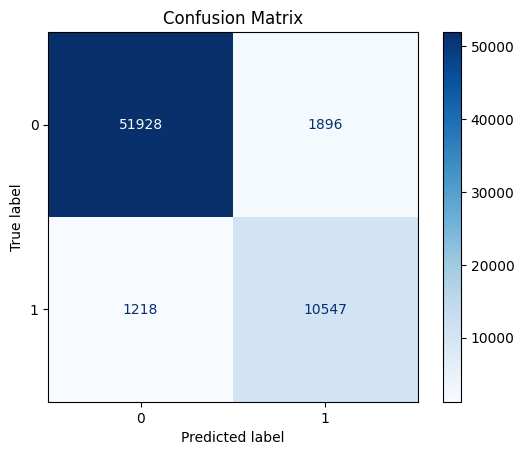

In [36]:
# training mode

# best parameters 
params = {
          'n_estimators': 200,
          'criterion': 'entropy',
          'max_depth': 10,
          'min_samples_split': 7,
          'min_samples_leaf': 6,
          'max_features': "sqrt",
          'bootstrap': True,
          'random_state': 42
         }

# training model
gbc = RandomForestClassifier(**params)
gbc.fit(X_resampled, y_resampled)

# making predictions
y_pred = gbc.predict(X_test_resampled)

# accuracy 
acc = accuracy_score(y_test_resampled, y_pred)
print("Accuracy of the model is: ", round(acc, 2))

# confusion matrix
cm = confusion_matrix(y_test_resampled, y_pred)

print(classification_report(y_test_resampled, y_pred))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')  # Use a colormap for better visualization
plt.title("Confusion Matrix")
plt.show()